In [1]:
import util
import plotting
import evaluation

import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
from tqdm import tqdm

import tensorflow as tf

In [2]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load model and test data

#### No preprocessing, different batch sizes

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [4]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'ref')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/model.h5

Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/ref_f8_c9_b32/model.h5

Loading H:/Santi/Models/ref_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/history

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/ref_f8_c9_b32/history

Loading H:/Santi/Models/ref_f8_c9_b256/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/frames_test

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/ref_f8_c9_b32/frames_test

Loading H:/Santi/Models/ref_f8_c9_b256/frames_test
Done.


In [5]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: ref_f8_c9_b8


 25%|████████████████                                                | 1/4 [00:09<00:29,  9.85s/it]


Model: ref_f8_c9_b16


 50%|████████████████████████████████                                | 2/4 [00:13<00:15,  7.89s/it]


Model: ref_f8_c9_b32


 75%|████████████████████████████████████████████████                | 3/4 [00:16<00:06,  6.51s/it]


Model: ref_f8_c9_b256


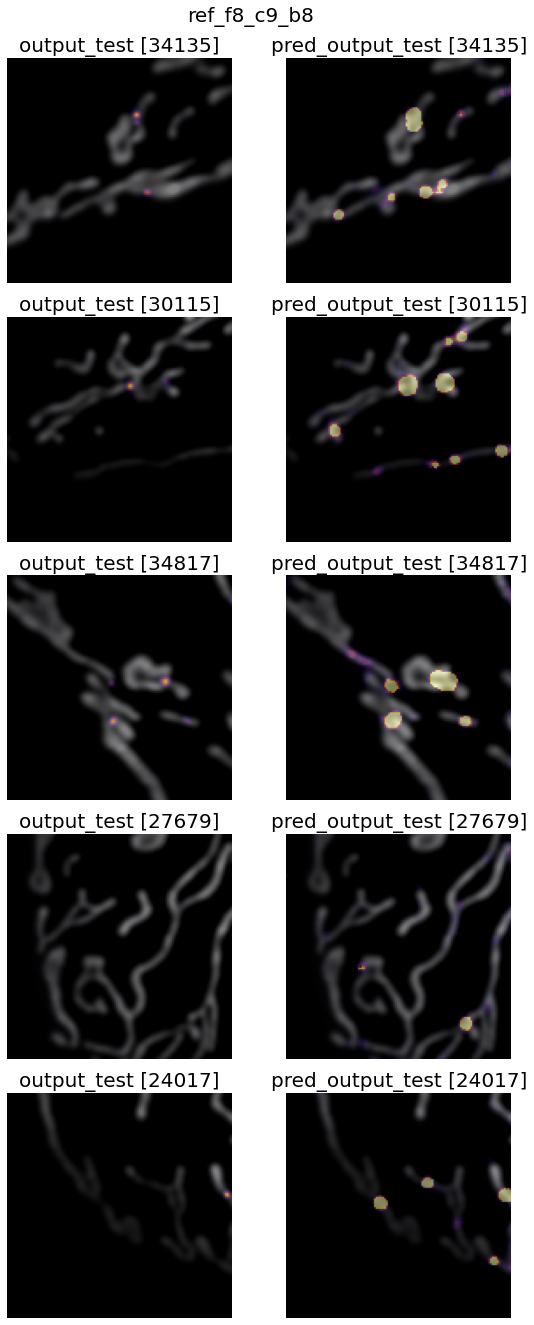

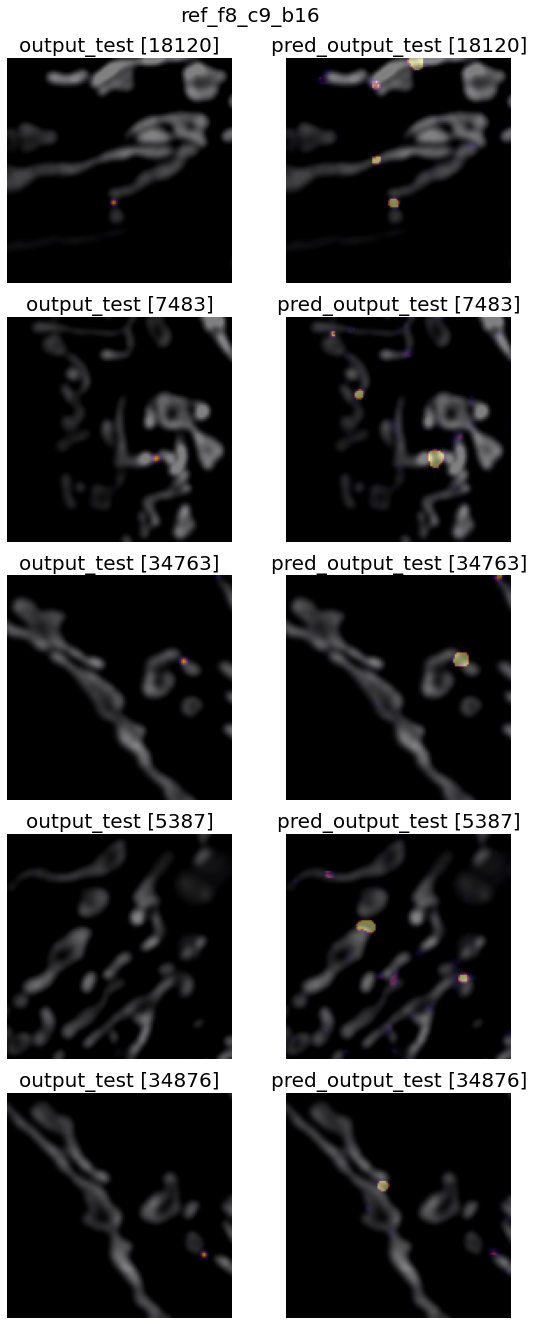

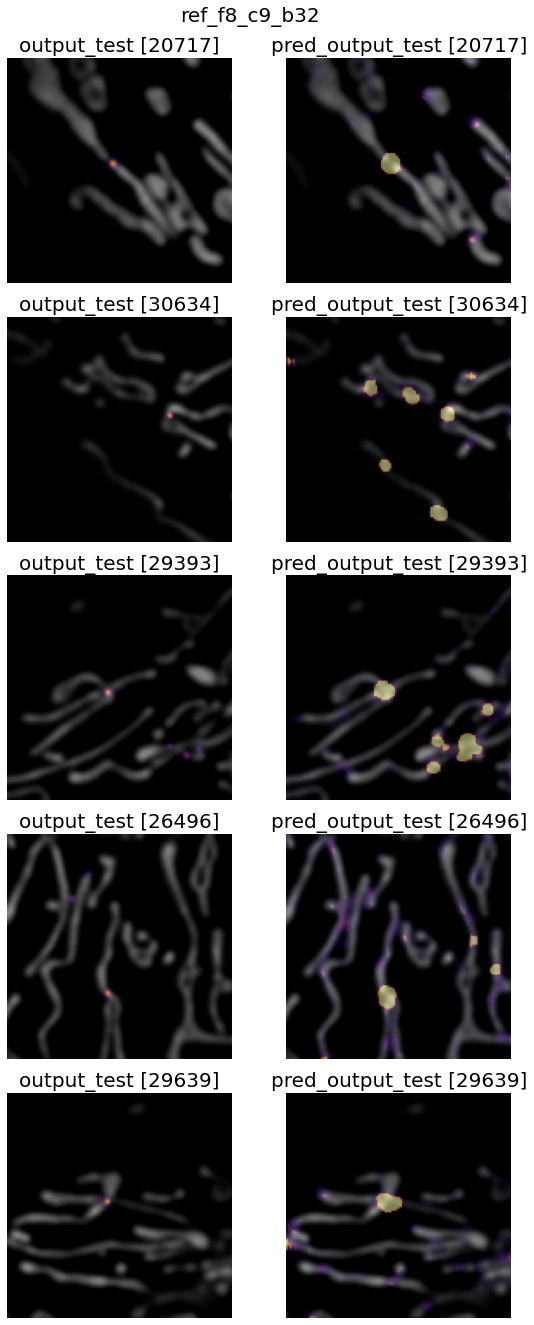

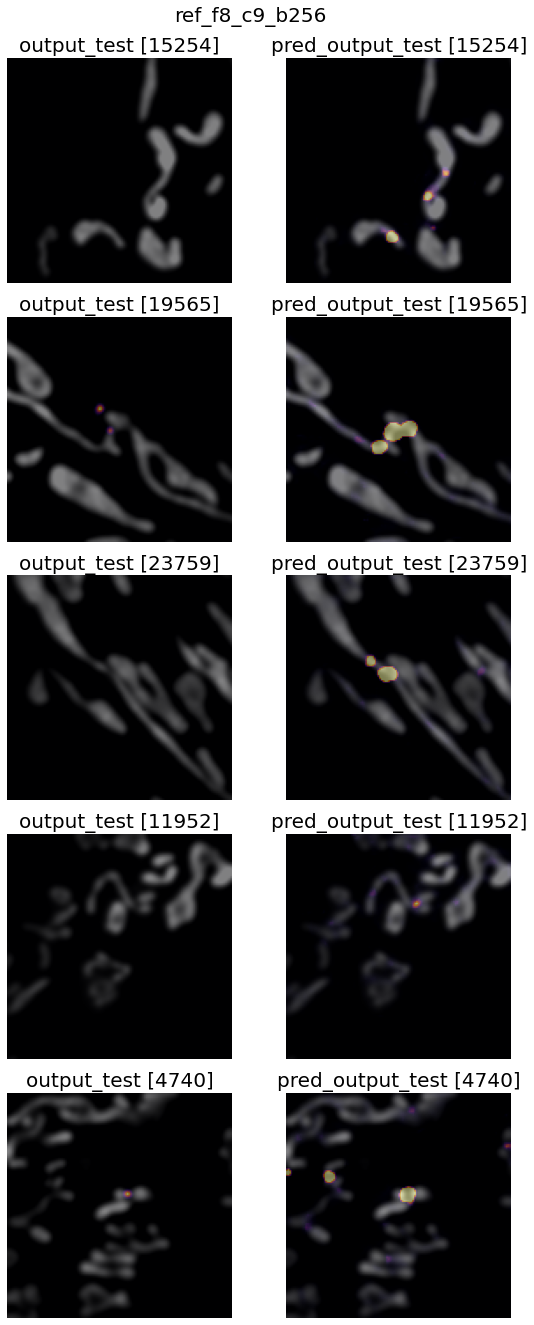

In [6]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [7]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(model), folder_name)

ref_f8_c9_b8: 0.76


C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


ref_f8_c9_b16: 0.76


ref_f8_c9_b32: 0.75


ref_f8_c9_b256: 0.76



Saving H:/Santi/Models/ref_f8_c9_b8/metrics

Saving H:/Santi/Models/ref_f8_c9_b16/metrics

Saving H:/Santi/Models/ref_f8_c9_b32/metrics

Saving H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


In [10]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(model), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/metrics

Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/ref_f8_c9_b32/metrics

Loading H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


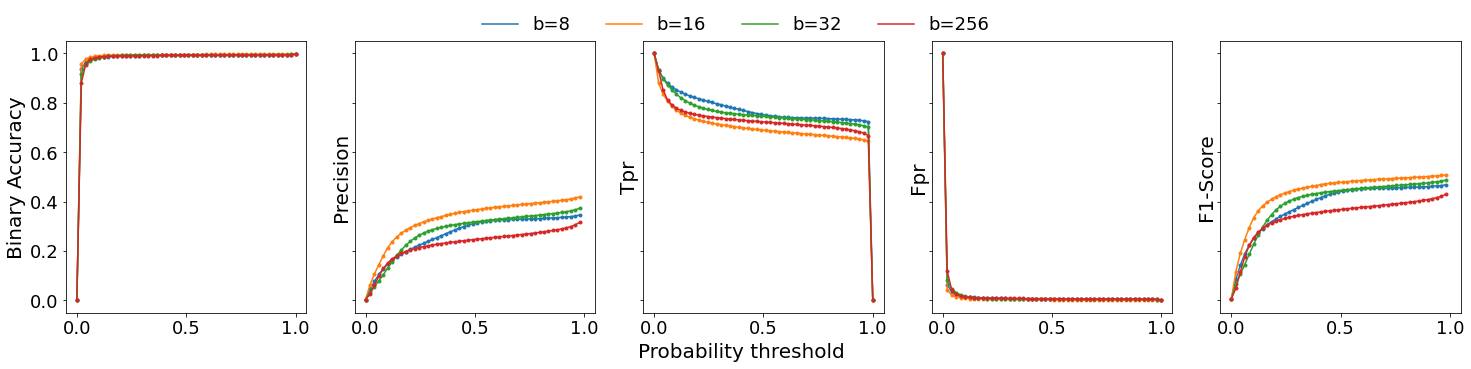

In [11]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name.title())
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)
plt.show()

#### MitoProc, different batch sizes

In [14]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [15]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'mp')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b32/model.h5

Loading H:/Santi/Models/mp_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/history

Loading H:/Santi/Models/mp_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b32/history

Loading H:/Santi/Models/mp_f8_c9_b256/history
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b32/frames_test

Loading H:/Santi/Models/mp_f8_c9_b256/frames_test
Done.


In [16]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: mp_f8_c9_b8


 25%|████████████████                                                | 1/4 [00:02<00:08,  2.73s/it]


Model: mp_f8_c9_b16


 50%|████████████████████████████████                                | 2/4 [00:09<00:07,  3.99s/it]


Model: mp_f8_c9_b32


 75%|████████████████████████████████████████████████                | 3/4 [00:21<00:06,  6.29s/it]


Model: mp_f8_c9_b256


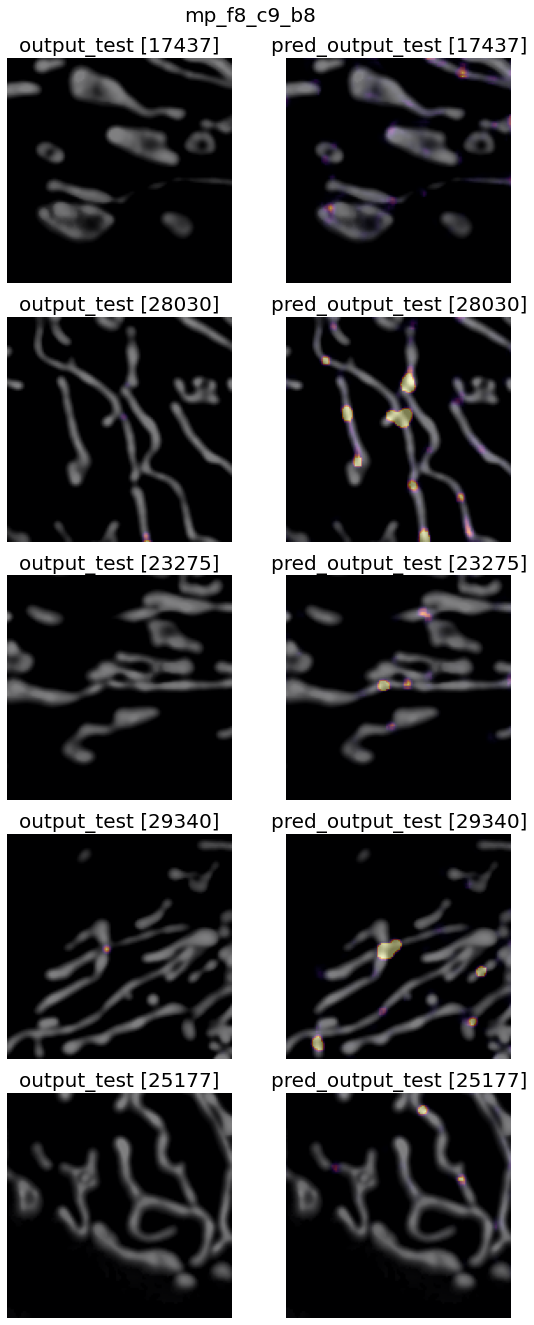

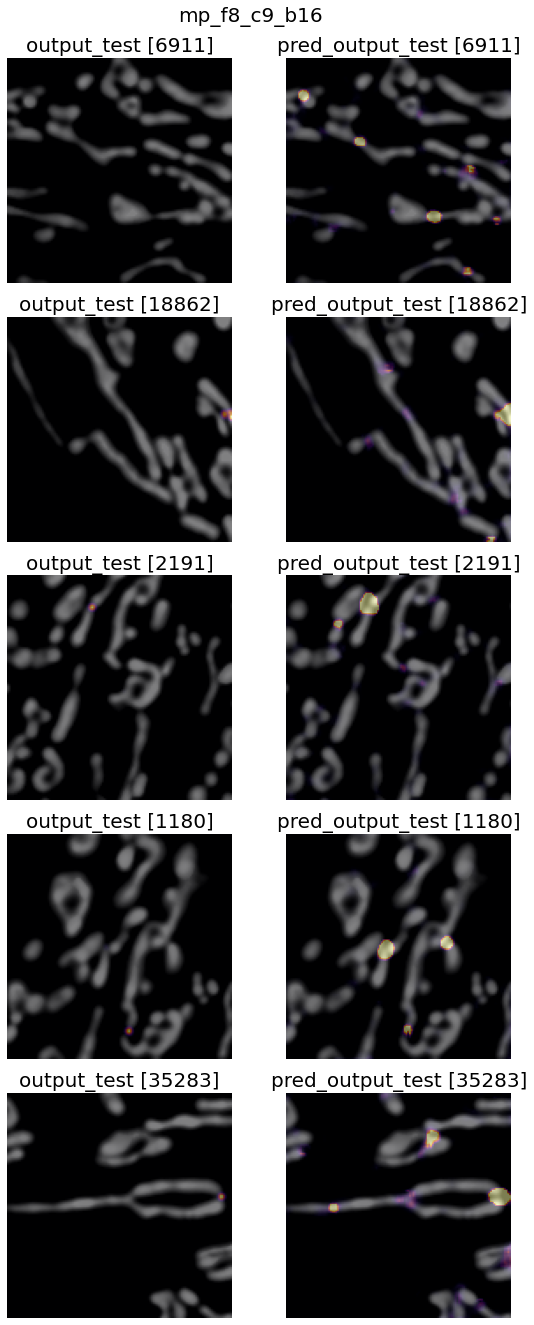

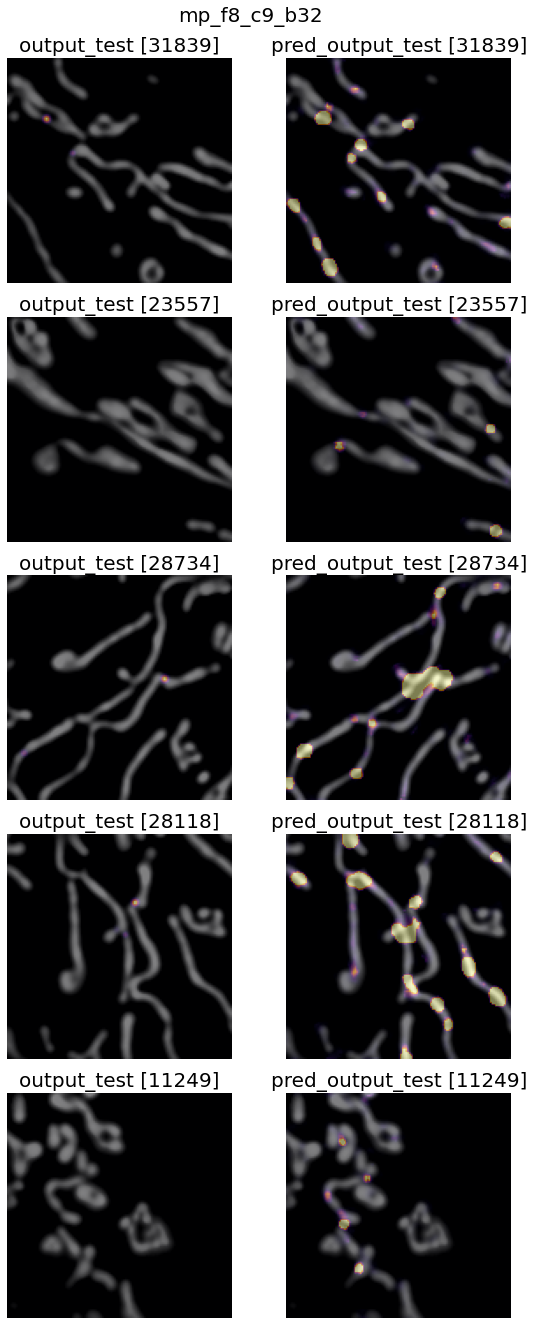

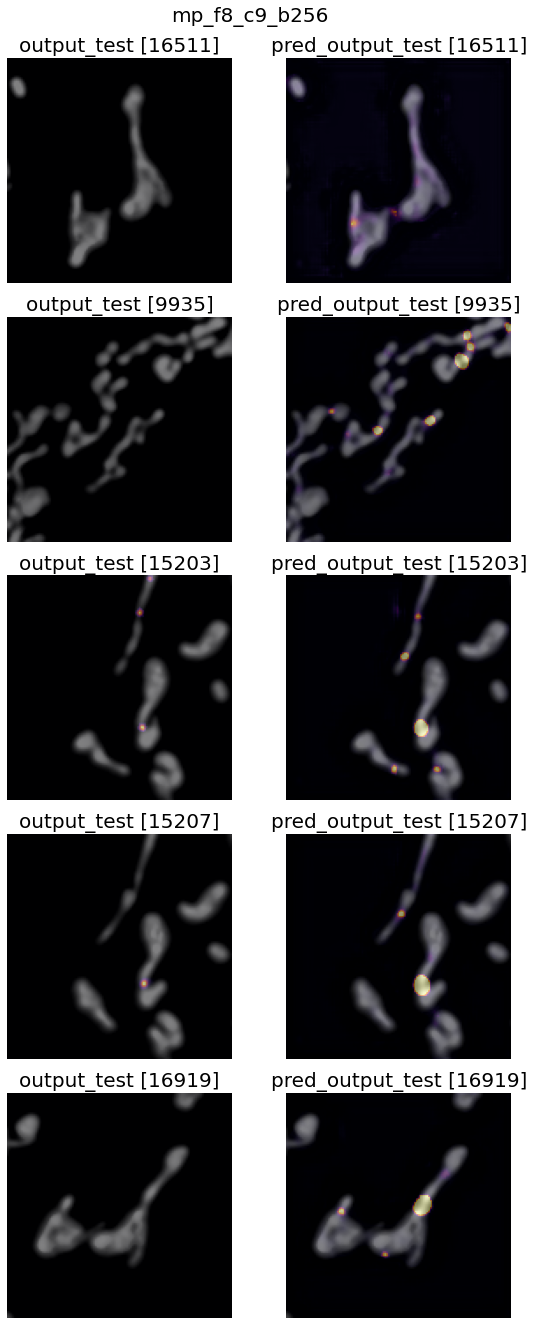

In [17]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [18]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

mp_f8_c9_b8: 0.75


C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


mp_f8_c9_b16: 0.77


mp_f8_c9_b32: 0.72


mp_f8_c9_b256: 0.74



Saving H:/Santi/Models/mp_f8_c9_b8/metrics

Saving H:/Santi/Models/mp_f8_c9_b16/metrics

Saving H:/Santi/Models/mp_f8_c9_b32/metrics

Saving H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


In [21]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b32/metrics

Loading H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


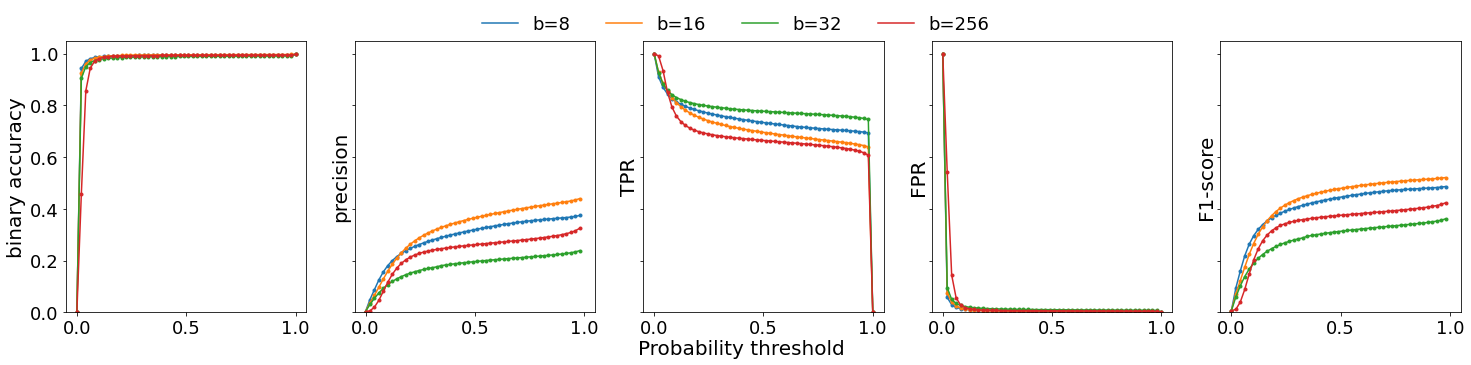

In [36]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0.01, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)

plt.show()

#### MitoProc vs Mito, batch_size=16

In [37]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [77]:
model_path = base_dir + 'Models/'
batch_size = 16
folder_name = ['ref_f8_c9_b%i'%batch_size, 'mp_f8_c9_b%i'%batch_size]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b16/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test
Done.


In [78]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/2 [00:00<?, ?it/s]


Model: ref_f8_c9_b16


 50%|████████████████████████████████                                | 1/2 [00:07<00:07,  7.55s/it]


Model: mp_f8_c9_b16


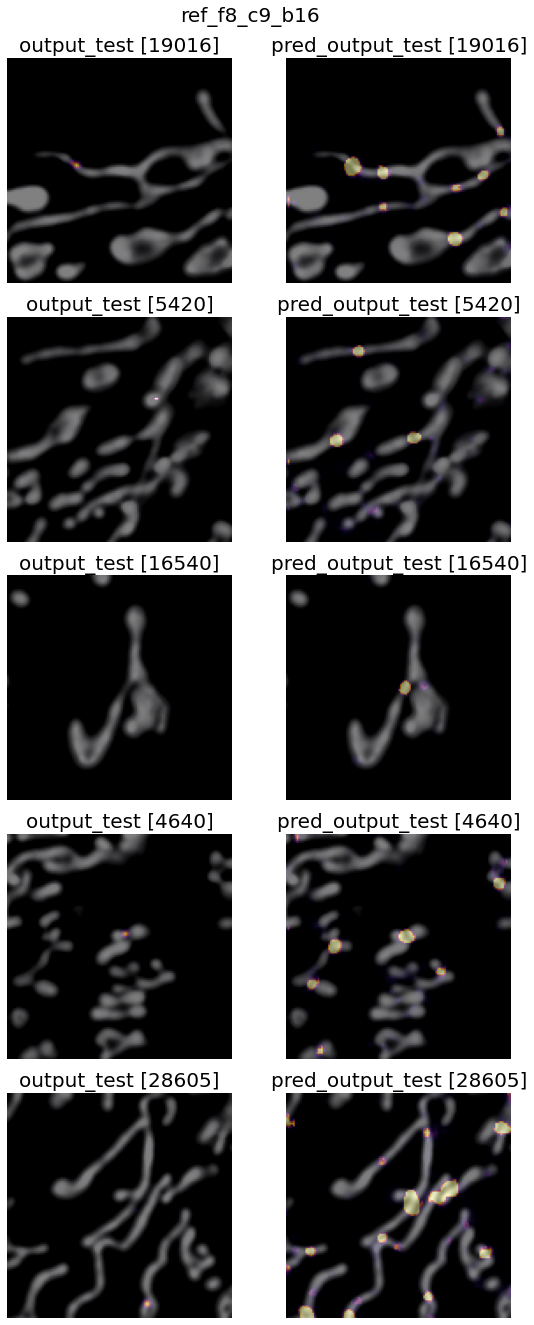

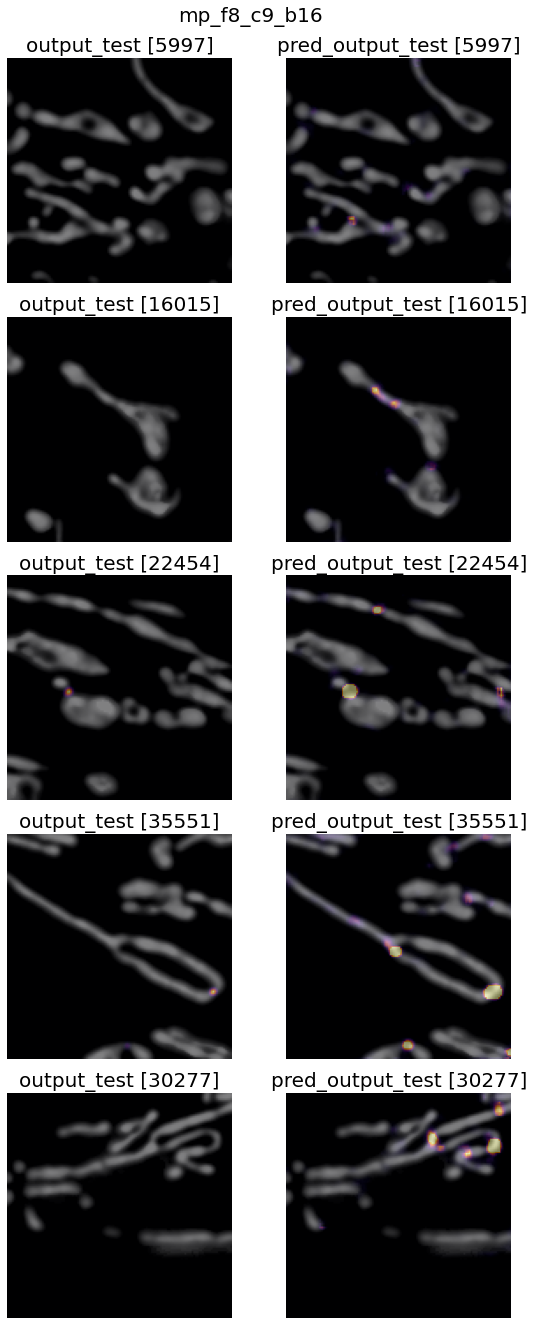

In [79]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [80]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics
Done.


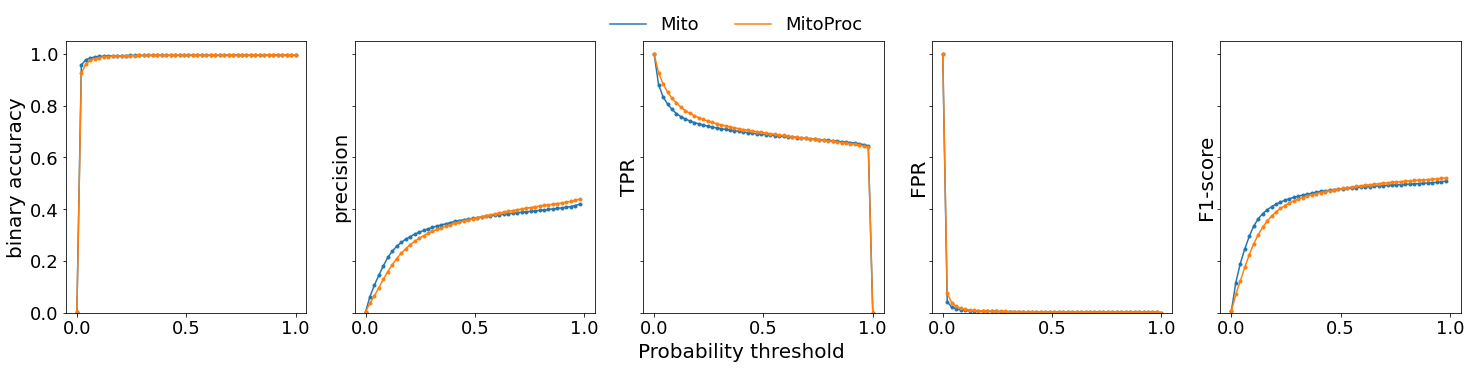

In [81]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['Mito', 'MitoProc'],
           loc='upper center', ncol=4, framealpha=0)

plt.show()

In [85]:
{model_name: np.nanmax(metrics[model_name]['F1-score']) for model_name in folder_name}

{'ref_f8_c9_b16': 0.5086196894102704, 'mp_f8_c9_b16': 0.520919459222525}

#### MitoProc & WatProc, different spot sizes

In [9]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

sigmas = np.arange(0.5, 2+0.5, 0.5)
nb_sigmas = sigmas.shape[0]

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, '_s')

output_data = {}

for model_name, s in zip(folder_name, sigmas):
  #Outputs
  output_data[model_name] = util.load_h5(data_path, 'WatProc_s'+str(s))

print('Outputs:', output_data[model_name].shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/WatProc_s0.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.0.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s2.0.h5
Converting to array
Outputs: (37000, 128, 128)


In [10]:
batch_size = 16
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b16_s0.5/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16_s1.0/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16_s1.5/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16_s2.0/model.h5
Done.

Loading H:/Santi/Models/mp_f8_c9_b16_s0.5/history

Loading H:/Santi/Models/mp_f8_c9_b16_s1.0/history

Loading H:/Santi/Models/mp_f8_c9_b16_s1.5/history

Loading H:/Santi/Models/mp_f8_c9_b16_s2.0/history
Done.

Loading H:/Santi/Models/mp_f8_c9_b16_s0.5/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16_s1.0/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16_s1.5/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16_s2.0/frames_test
Done.


In [11]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[model_name][frames_test[model_name]]
  del output_data[model_name]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
del input_data

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: mp_f8_c9_b16_s0.5


 25%|████████████████                                                | 1/4 [00:02<00:07,  2.63s/it]


Model: mp_f8_c9_b16_s1.0


 50%|████████████████████████████████                                | 2/4 [00:05<00:05,  2.62s/it]


Model: mp_f8_c9_b16_s1.5


 75%|████████████████████████████████████████████████                | 3/4 [00:07<00:02,  2.61s/it]


Model: mp_f8_c9_b16_s2.0


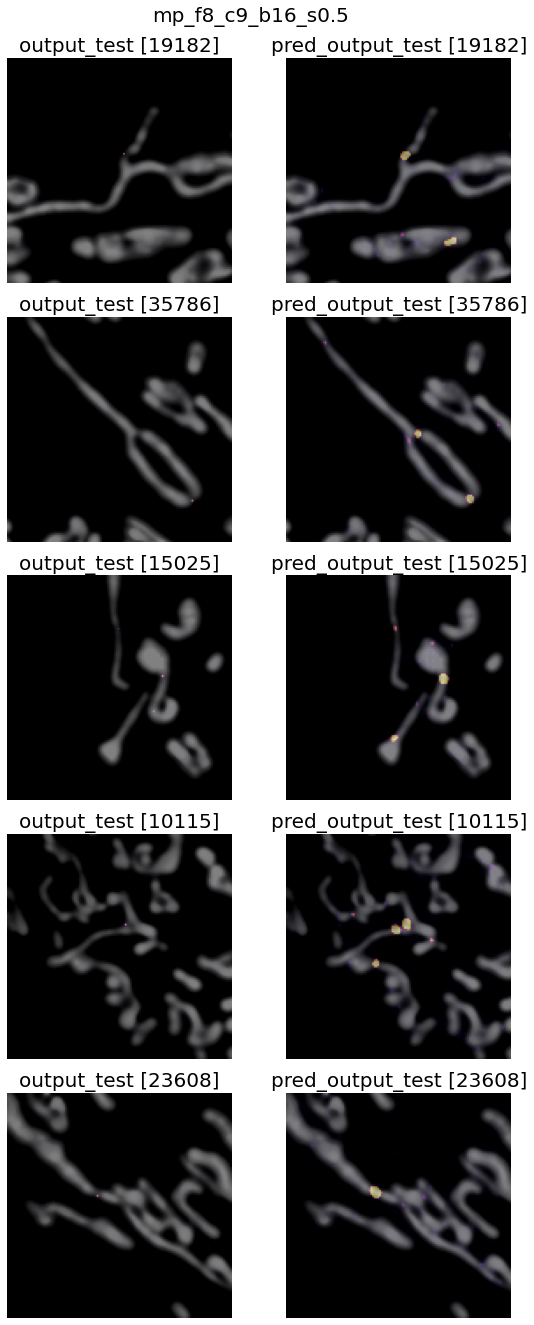

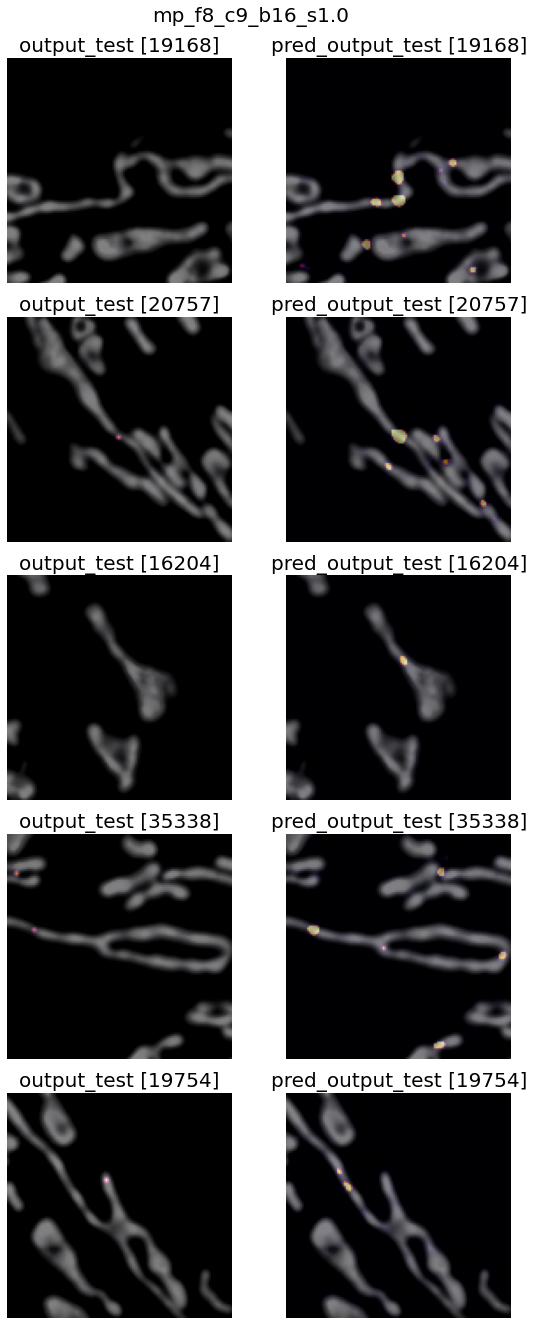

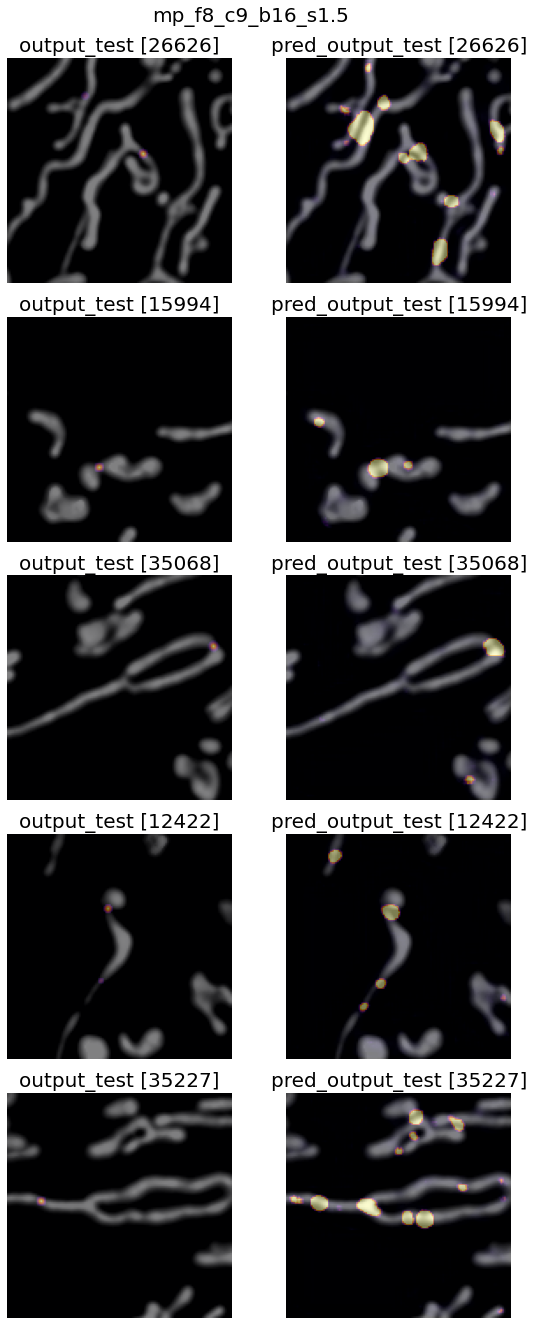

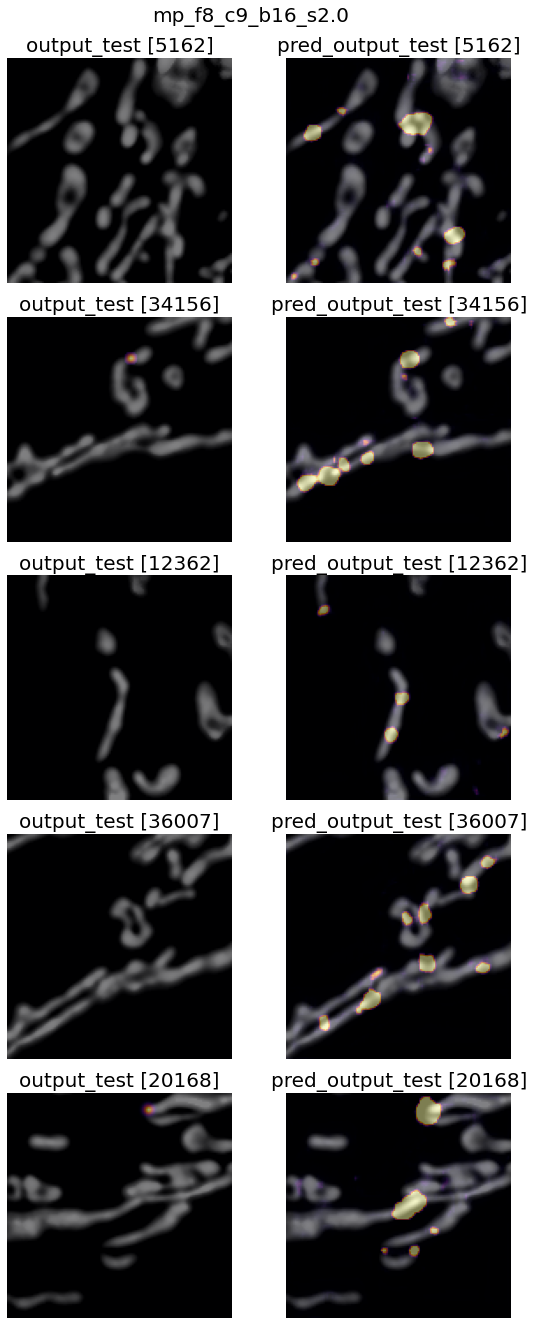

In [12]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [13]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

mp_f8_c9_b16_s0.5: 0.72


C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


mp_f8_c9_b16_s1.0: 0.66


mp_f8_c9_b16_s1.5: 0.67


mp_f8_c9_b16_s2.0: 0.62



Saving H:/Santi/Models/mp_f8_c9_b16_s0.5/metrics

Saving H:/Santi/Models/mp_f8_c9_b16_s1.0/metrics

Saving H:/Santi/Models/mp_f8_c9_b16_s1.5/metrics

Saving H:/Santi/Models/mp_f8_c9_b16_s2.0/metrics
Done.


In [14]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b16_s0.5/metrics

Loading H:/Santi/Models/mp_f8_c9_b16_s1.0/metrics

Loading H:/Santi/Models/mp_f8_c9_b16_s1.5/metrics

Loading H:/Santi/Models/mp_f8_c9_b16_s2.0/metrics
Done.


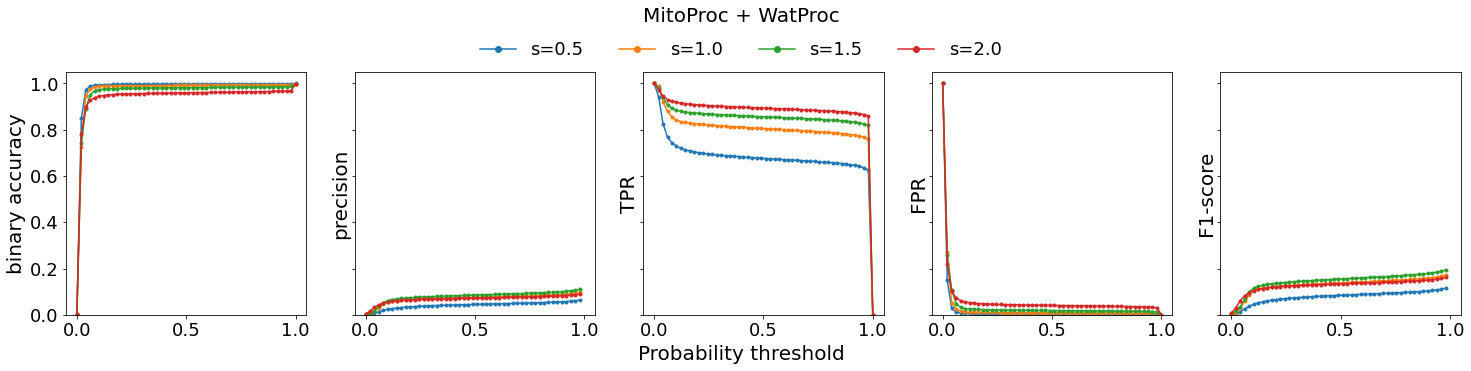

In [74]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f'%s for s in sigmas],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=4, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

In [77]:
metricsAtMaxThreshold = {model_name: {metric_name: metrics[model_name]['precision'][-2]  for metric_name in ['precision', 'TPR', 'F1-score']} \
                         for model_name in folder_name}



{'mp_f8_c9_b16_s0.5': {'precision': 0.0635124143006546,
  'TPR': 0.0635124143006546,
  'F1-score': 0.0635124143006546},
 'mp_f8_c9_b16_s1.0': {'precision': 0.09725733183813887,
  'TPR': 0.09725733183813887,
  'F1-score': 0.09725733183813887},
 'mp_f8_c9_b16_s1.5': {'precision': 0.11032269294239594,
  'TPR': 0.11032269294239594,
  'F1-score': 0.11032269294239594},
 'mp_f8_c9_b16_s2.0': {'precision': 0.08920583184766322,
  'TPR': 0.08920583184766322,
  'F1-score': 0.08920583184766322}}

In [78]:
def plot_metrics(metrics, color=None, title=None, ylim=[0.7, 1], loc=(0.56, 0.75), ncol=None, legend=True, ax=None, **kwargs):
  fontsize = 20
  N = len(metrics)
  if ax is None:
    fig, ax = plt.subplots(figsize=(N, 5))
  else:
    fig, ax = ax.figure, ax
  if color is None:
    color = mpl.cm.get_cmap('tab10')(range(N))  
  xticks = range(N)
  
  yticks = np.arange(ylim[0], ylim[1]+0.1, 0.1).round(1)
  vals = metrics.values
  ax.set_title(title, size=18)
  ax.bar(xticks, vals, color=color, **kwargs)
  ax.set(xticks=_xticks, yticks=yticks)
  ax.set(xticklabels=[], yticklabels=yticks)
  ax.set_ylim(ylim)  
  ax.set(xticks=[])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if legend:
    if ncol is not None:
      ax.legend(handles=[plt.bar([0], [0], color=c) for c in color], labels=list(metrics.index), 
                loc=loc, framealpha=1, fontsize=_fontsize, ncol=ncol)
    else:
      ax.legend(handles=[plt.bar([0], [0], color=c) for c in _color], labels=list(metrics.index), 
          loc=loc, framealpha=1, fontsize=fontsize)
  return ax

def plot_metrics_comparison(metrics, color=None, title=None, ax=None, legend=True, **kwargs):
  scale = 1.5
  N, n = metrics.shape
  if ax is None:
    fig, ax = plt.subplots(figsize=(N*scale, 6))
  else:
    fig = ax.figure
  if color is None:
    color = mpl.cm.get_cmap('tab10')(np.linspace(0, n*0.1, n))  
  keys = list(metrics.index)
  i = np.arange(N)
  width = 0.7*(i[1]-i[0])/n
  for j, method in enumerate(metrics):
    vals = metrics[method]
    ax.bar(i + _width*(j-(n-1)/2), vals, width=width, align='center', 
            color=color[j], edgecolor='white', label=method, **kwargs)

  ax.set_title(title, size=24)
  ax.set_xticks(i)
  ax.set_xticklabels(keys)
  ax.set_ylim([0.7, 1])  
  fig.subplots_adjust(top=0.78)
  if legend:
    fig.legend(loc=(0.12, 0.88), ncol=n//2 + 1)
  return ax

IndentationError: expected an indented block (<ipython-input-78-857b9173a098>, line 54)